In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import kstest, norm


# funções desenvolvidas para o projeto
from src.config import DADOS_TRATADOS
from src.auxiliares import analise_levene, analise_ttest_ind, analise_mannwhitneyu, remover_outliers

In [2]:
df_diabetes = pd.read_parquet(DADOS_TRATADOS)
df_diabetes.head()

,Diabetes,PressaoAlta,ColesterolAlto,ColesterolExame,IMC,Fumante,AVC,ProblemaCardiaco,AtividadeFísica,ConsumoFrutas,...,PlanoSaude,SemDinheiroConsulta,SaudeGeral,SaudeMental,SaudeFisica,DificuldadeLocomocao,Genero,Idade,Educacao,FaixaRenda
0,Não,Sim,Não,Sim,26,Não,Não,Não,Sim,Não,...,Sim,Não,Boa,5,30,Não,Masculino,35-39,faculdade,75.000+
1,Não,Sim,Sim,Sim,26,Sim,Sim,Não,Não,Sim,...,Sim,Não,Boa,0,0,Não,Masculino,75-79,faculdade,75.000+
2,Não,Não,Não,Sim,26,Não,Não,Não,Sim,Sim,...,Sim,Não,Excelent,0,10,Não,Masculino,80+,faculdade,75.000+
3,Não,Sim,Sim,Sim,28,Sim,Não,Não,Sim,Sim,...,Sim,Não,Boa,0,3,Não,Masculino,70-74,faculdade,75.000+
4,Não,Não,Não,Sim,29,Sim,Não,Não,Sim,Sim,...,Sim,Não,Muito Boa,0,0,Não,Feminino,55-59,faculdade inc. tecnico,75.000+


In [3]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   Diabetes                70692 non-null  category
 1   PressaoAlta             70692 non-null  category
 2   ColesterolAlto          70692 non-null  category
 3   ColesterolExame         70692 non-null  category
 4   IMC                     70692 non-null  int8    
 5   Fumante                 70692 non-null  category
 6   AVC                     70692 non-null  category
 7   ProblemaCardiaco        70692 non-null  category
 8   AtividadeFísica         70692 non-null  category
 9   ConsumoFrutas           70692 non-null  category
 10  ConsumoVegetais         70692 non-null  category
 11  ConsumoBebidaAlcoolica  70692 non-null  category
 12  PlanoSaude              70692 non-null  category
 13  SemDinheiroConsulta     70692 non-null  category
 14  SaudeGeral            

Separação das colunas de acordo com o tipo de dado que ela possui:
Núméricos, Categóricos, Binários, Não Binários e Coluna alvo

In [4]:
coluna_alvo = 'Diabetes'

colunas_numericas = df_diabetes.select_dtypes(include="number").columns.to_list()

colunas_categoricas = df_diabetes.select_dtypes(include="category").columns.to_list()
colunas_categoricas.remove(coluna_alvo)

colunas_binarias = df_diabetes.nunique()[df_diabetes.nunique() == 2].index.to_list()
colunas_binarias.remove(coluna_alvo)

colunas_nao_binarias = list(set(colunas_categoricas) - set(colunas_binarias))


## Análise Exploratória dos dados

Variáveis numéricas:

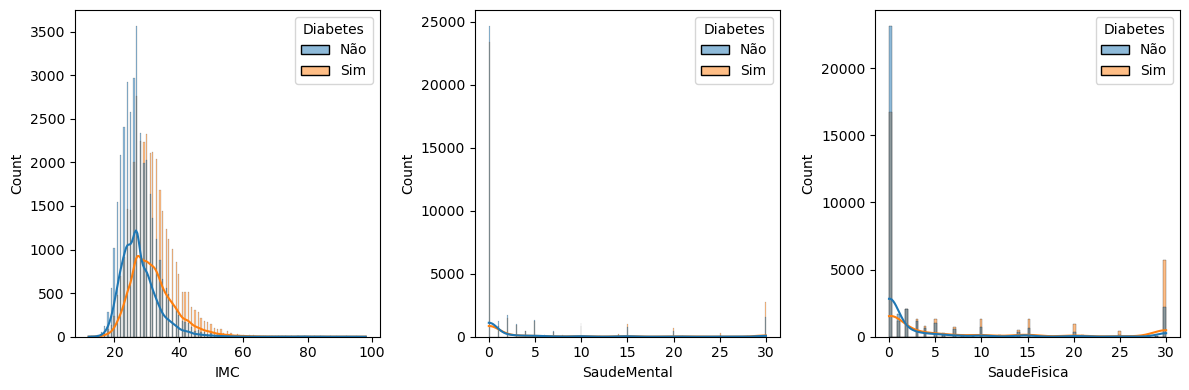

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
for ax, coluna in zip(axs, colunas_numericas):
    sns.histplot(data=df_diabetes, x=coluna, kde=True, hue=coluna_alvo, ax=ax)

plt.tight_layout()
plt.show()

* Pelos gráficos acima, pode-se perceber que tanto as variáveis saúde física e saúde mental nao seguem uma distribuição normal, enquanto o IMC parece seguir.
* O Gráfico do IMC nos leva a investigar melhor se o IMC pode influenciar no Diabetes

In [6]:
df_diabetes.groupby(coluna_alvo, observed=False).describe().T

Diabetes                    Não           Sim
IMC         count  35346.000000  35346.000000
            mean      27.769960     31.944011
            std        6.187636      7.363401
            min       12.000000     13.000000
            25%       24.000000     27.000000
            50%       27.000000     31.000000
            75%       31.000000     35.000000
            max       98.000000     98.000000
SaudeMental count  35346.000000  35346.000000
            mean       3.042268      4.461806
            std        7.208408      8.947717
            min        0.000000      0.000000
            25%        0.000000      0.000000
            50%        0.000000      0.000000
            75%        2.000000      3.000000
            max       30.000000     30.000000
SaudeFisica count  35346.000000  35346.000000
            mean       3.666355      7.954479
            std        8.098339     11.301491
            min        0.000000      0.000000
            25%        0.000000      0.000000
            50%        0.000000      1.000000
            75%        2.000000     15.000000
            max       30.000000     30.000000

In [7]:
df_diabetes.groupby(coluna_alvo, observed=False).skew(numeric_only=True)

,IMC,SaudeMental,SaudeFisica
Diabetes,,,
Não,2.231015,2.808070,2.480202
Sim,1.527018,2.065169,1.150047


Uma Skew Positiva descreve uma curva mais longa na cauda direita, o que é compatível com o gráfico de IMC acima

In [8]:
df_diabetes.groupby(coluna_alvo, observed=False)[colunas_numericas].apply(pd.DataFrame.kurtosis)

,IMC,SaudeMental,SaudeFisica
Diabetes,,,
Não,12.901012,7.012218,4.910598
Sim,5.717382,2.873176,-0.341922


Como há uma amostra maior que 5000 dados usaremos o KS test, já que temos curva normal para os dois gráficos

In [9]:
dados_imc_sim = df_diabetes.query("Diabetes == 'Sim'")['IMC'].values

dados_imc_nao = df_diabetes.query("Diabetes == 'Não'")['IMC'].values

In [10]:
print(f"Resultado kstest Não: {kstest(
    dados_imc_nao, 
    norm.cdf, 
    args=(dados_imc_nao.mean(), dados_imc_nao.std(),
          
          ))}")

print(f"Resultado kstest Sim: {kstest(
    dados_imc_sim, 
    norm.cdf, 
    args=(dados_imc_sim.mean(), dados_imc_sim.std(),
          ))}")

Resultado kstest Não: KstestResult(statistic=0.1209153634702329, pvalue=0.0, statistic_location=28, statistic_sign=1)
Resultado kstest Sim: KstestResult(statistic=0.10452803408478695, pvalue=0.0, statistic_location=33, statistic_sign=1)


Para verificar a homogeneidade de variâncias, faremos o teste de Levene:

In [11]:
df_diabetes_imc = pd.DataFrame({'Sim': dados_imc_sim, 'Não': dados_imc_nao})
df_diabetes.head()

,Diabetes,PressaoAlta,ColesterolAlto,ColesterolExame,IMC,Fumante,AVC,ProblemaCardiaco,AtividadeFísica,ConsumoFrutas,...,PlanoSaude,SemDinheiroConsulta,SaudeGeral,SaudeMental,SaudeFisica,DificuldadeLocomocao,Genero,Idade,Educacao,FaixaRenda
0,Não,Sim,Não,Sim,26,Não,Não,Não,Sim,Não,...,Sim,Não,Boa,5,30,Não,Masculino,35-39,faculdade,75.000+
1,Não,Sim,Sim,Sim,26,Sim,Sim,Não,Não,Sim,...,Sim,Não,Boa,0,0,Não,Masculino,75-79,faculdade,75.000+
2,Não,Não,Não,Sim,26,Não,Não,Não,Sim,Sim,...,Sim,Não,Excelent,0,10,Não,Masculino,80+,faculdade,75.000+
3,Não,Sim,Sim,Sim,28,Sim,Não,Não,Sim,Sim,...,Sim,Não,Boa,0,3,Não,Masculino,70-74,faculdade,75.000+
4,Não,Não,Não,Sim,29,Sim,Não,Não,Sim,Sim,...,Sim,Não,Muito Boa,0,0,Não,Feminino,55-59,faculdade inc. tecnico,75.000+


In [12]:
analise_levene(df_diabetes_imc, centro="median")

Teste de Levene
Ao menos uma variância é diferente (valor P: 0.000)


Pelo teste de Levene as variâncias são diferentes

Análise T Test:

In [13]:
analise_ttest_ind(df_diabetes_imc, variancias_iguais=False)

Teste t de Student
estatistica_ttest=81.591
Rejeita a hipótese nula (valor p: 0.000)


Análise Mannwhitneyu

In [14]:
analise_mannwhitneyu(df_diabetes_imc)

Teste de Mann-Whitney
estatistica_mw=861173484.000
Rejeita a hipótese nula (valor p: 0.000)


## Análise sem Outliers:

In [15]:
df_diabetes_sem_outlier = df_diabetes.copy()

In [16]:
for coluna in colunas_numericas:
    df_diabetes_sem_outlier[coluna] = remover_outliers(df_diabetes_sem_outlier[coluna])

df_diabetes_sem_outlier.describe()

,IMC,SaudeMental,SaudeFisica
count,68511.000000,58876.000000,60068.000000
mean,29.129673,0.526615,1.880619
std,5.695466,1.271375,3.727202
min,13.000000,0.000000,0.000000
25%,25.000000,0.000000,0.000000
50%,28.000000,0.000000,0.000000
75%,33.000000,0.000000,2.000000
max,45.000000,5.000000,15.000000
